## This code trains an encoder/decoder for 1 channel of the pnnl datasets.

Make sure the channel is set:

channel = 1,2 = velocity_y, volume_frac


## Imports

In [ ]:
# EXPORT
# --- Must haves ---
import os, sys
sys.path.append('..')

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.cuda as cuda
import torch.nn as nn
import torchvision
import torch.nn.functional as F

from surrogates4sims.pnnlDatasets import CCSI_2D

from surrogates4sims.utils import create_opt, create_one_cycle, find_lr, printNumModelParams, \
                                    rmse, writeMessage, plotSampleWprediction, plotSampleWpredictionByChannel, \
                                    plotSample, curl, jacobian, stream2uv, convertSimToImage, pkl_save, pkl_load, \
                                    create_1_channel_movie

from surrogates4sims.models import Generator, Encoder, ConvDeconvFactor2

from surrogates4sims.train import trainEpoch, validEpoch

import numpy as np
from tqdm import tqdm
from copy import deepcopy
import matplotlib.pyplot as plt
from glob import glob

In [ ]:
torch.__version__

'1.7.0'

## Settings

In [ ]:
DEBUG = False
# model name, for tensorboard recording and checkpointing purposes.
versionName = "pnnl_ConvDeconvFactor2"

# GPU Numbers to use. Comma seprate them for multi-GPUs.
gpu_ids = "0"
versionName = versionName + '_GPUs{}'.format(gpu_ids.replace(',',''))
# path to load model weights.
pretrained_path = None

# rate at which to record metrics. (number of batches to average over when recording metrics, e.g. "every 5 batches")
tensorboard_rate = 5

# number of epochs to train. This is defined here so we can use the OneCycle LR Scheduler.
epochs = 1000

# Data Directory
channel = 2
gridsize = 128
dataDirec = '/data/ccsi/pnnl_liquid_inlet/channel_{}/gridsize_{}'.format(channel,gridsize)
preprocess = False # keep this as false until using the long runtime loader
testSplit = .2
AE = False
numWorkers = 2

# checkpoint directory
cps = 'cps'
tensorboard_direc = "tb"

findLRs = False  

# hyper-params
seed = 1234
np.random.seed(seed)
bz = 128
use_sigmoid_output_layer = True
window_size = 0 #important to set this to zero to prevent creation of window_size elements of Y for each X
numSamplesToKeep = np.infty #if not debugging
latentDim = 128
filters = 128
num_conv = 4 # breaks when less than 2
simLen = 500
stack = True
doJacobian = False
createStreamFcn = False
repeat = 3
skip_connection = False
patience = 2
act = nn.ELU()
if DEBUG:
    epochs = 2
    numSamplesToKeep = 2
    
versionName = versionName + '_channel{}_gridsize{}_latentDim{}_filters{}_bz{}_numConv{}_jacobian{}_sigmoid_out{}_epochs{}_repeat{}'.format(
    channel,gridsize,latentDim,filters,bz,num_conv,doJacobian,use_sigmoid_output_layer,epochs,repeat)
versionName

'pnnl_ConvDeconvFactor2_GPUs0_channel2_gridsize128_latentDim256_filters128_bz128_numConv4_jacobianFalse_sigmoid_outTrue_epochs1000_stackTrue'

### Select Personal GPUs

In [ ]:
!nvidia-smi

Mon Nov  9 12:10:00 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN Xp            On   | 00000000:02:00.0 Off |                  N/A |
| 39%   53C    P0    83W / 250W |      1MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN Xp            On   | 00000000:03:00.0 Off |                  N/A |
| 23%   20C    P8     8W / 250W |      1MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [ ]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]=gpu_ids

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [ ]:
if device.type == 'cuda':
    print(cuda.is_available())
    print(cuda.device_count())
    print(cuda.current_device())
    print(cuda.get_device_name())

True
1
0
TITAN Xp


In [ ]:
a = torch.zeros(5, device=device.type)
!nvidia-smi

Mon Nov  9 12:10:02 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN Xp            On   | 00000000:02:00.0 Off |                  N/A |
| 38%   53C    P2    83W / 250W |    605MiB / 12196MiB |      3%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN Xp            On   | 00000000:03:00.0 Off |                  N/A |
| 23%   20C    P8     8W / 250W |      1MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

## Datasets & Loaders

In [ ]:
sims = glob(os.path.join(dataDirec,'*.pkl'))
numSims = len(sims)
idx = int(testSplit*numSims)
testInds = np.linspace(1,numSims-2,idx).astype('int')
trainInds = list(set(np.arange(0,numSims)).difference(set(testInds)))
# perm = np.random.permutation(numSims)
# testInds = perm[:idx]
# trainInds = perm[idx:]
testSimFiles = [sims[idx] for idx in testInds]
trainSimFiles = [sims[idx] for idx in trainInds]
len(testSimFiles), len(trainSimFiles)

(10, 40)

In [ ]:
testDataset = CCSI_2D(testSimFiles,doPreprocess=preprocess,numToKeep=numSamplesToKeep,channel=channel,AE=AE,
                      w=window_size)
trainDataset = CCSI_2D(trainSimFiles,doPreprocess=preprocess,numToKeep=numSamplesToKeep,channel=channel,AE=AE,
                      w=window_size)

In [ ]:
trainDataLoader = DataLoader(dataset=trainDataset, batch_size=bz, shuffle=True, drop_last=True, num_workers=numWorkers)
testDataLoader = DataLoader(dataset=testDataset, batch_size=bz, num_workers=numWorkers)
len(trainDataLoader), len(testDataLoader)

(156, 40)

## Model

Currently, the models need to take data to be built. It's kinda weird. I may look into fix this later. 

In [ ]:
X, Y, p_x, p_y = next(iter(trainDataLoader))
X, Y, p_x, p_y = X.to(device), Y.to(device), p_x.to(device), p_y.to(device)
X.shape, Y.shape, p_x.shape, p_y.shape

(torch.Size([128, 1, 128, 128]),
 torch.Size([128, 0, 1, 128, 128]),
 torch.Size([128, 2]),
 torch.Size([128, 0, 2]))

In [ ]:
model = ConvDeconvFactor2(X, filters, latentDim, num_conv, repeat,
                          skip_connection, stack, conv_k=3, last_k=3, 
                          act=act, return_z=True, stream=createStreamFcn, device=device, 
                          use_sigmoid_output_layer=use_sigmoid_output_layer)

model = model.to(device)
if len(gpu_ids.split(',')) > 1:
    model = nn.DataParallel(model)

In [ ]:
printNumModelParams(model)

36 layers require gradients (unfrozen) out of 36 layers
46,017,283 parameters require gradients (unfrozen) out of 46,017,283 parameters


In [ ]:
Xhat,z = model(X, p_x)
Xhat.shape, z.shape

(torch.Size([128, 1, 128, 128]), torch.Size([128, 256]))

In [ ]:
np.allclose(z[:,-2:].detach().cpu(),p_x.cpu())

True

## Loss Function

In [ ]:
def L2_relative_loss(pred, target):
    return torch.norm(pred - target)/torch.norm(target)


def L1_loss(pred, target):
    return torch.mean(torch.abs(pred - target))


def jacobian_loss(pred, target, device='cpu'):
    return L1_loss(jacobian(pred, device), jacobian(target, device))


def curl_loss(pred, target, device):
    return L1_loss(curl(pred, device), curl(target, device))


L = nn.MSELoss()


def p_loss(pred, target):
    return L(pred[:, -target.shape[1]:], target)


def loss(pred, target, device):
    
    if createStreamFcn:
        pred = stream2uv(pred, device)
        
    L = L2_relative_loss(pred, target)
    Lj = 0
    if doJacobian:
        Lj = jacobian_loss(pred, target, device)
        
    return L + Lj

In [ ]:
pred = stream2uv(Xhat,device)
pred.shape

torch.Size([128, 2, 128, 128])

In [ ]:
loss(pred,X,device)

tensor(3.1392, device='cuda:0', grad_fn=<AddBackward0>)

## Set LR

In [ ]:
if findLRs and (len(gpu_ids.split(','))==1): # doesn't work for multigpu???
    model.return_z = False
    opt = create_opt(1e-7,model)
    find_lr(model,opt,L,device,trainDataLoader)
    model.return_z = True

In [ ]:
max_lr = .0001
start_lr = 5*max_lr/10
#opt = create_opt(max_lr,model)
#lr_scheduler = create_one_cycle(opt,max_lr,epochs,trainDataLoader)
opt = torch.optim.Adam(model.parameters(),lr=max_lr,betas=(.5,.999))
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt,patience=patience)

In [ ]:
versionName = versionName + '_lr{}'.format(str(max_lr))
versionName

'pnnl_ConvDeconvFactor2_GPUs0_channel2_gridsize128_latentDim256_filters128_bz128_numConv4_jacobianFalse_sigmoid_outTrue_epochs1000_stackTrue_lr0.0001'

## Train

In [ ]:
def trainEpoch(myDataLoader, tensorboard_writer, model, opt, p_loss, loss,
               metric, lr_scheduler, tensorboard_rate, device,
               tensorboard_recorder_step, total_steps):
    running_loss = 0.0
    running_rmse = 0.0
    total_loss = 0.0
    running_ploss = 0.0
    for i, sampleBatch in enumerate(myDataLoader, start=1):

        # --- Main Training ---
        
        # gpu
        X, Y, p_x, p_y = sampleBatch
        X = X.to(device)
        p_x = p_x.to(device)

        # zero the parameter gradients
        opt.zero_grad()

        X_hat, z = model(X, p_x)
        #pl = p_loss(z,p)
        ll = loss(X_hat,X,device)
        combined_loss = ll #pl + ll
        combined_loss.backward()
        opt.step()
        
        # loss
        batch_loss = combined_loss.item()
        running_loss += batch_loss
        total_loss += batch_loss
        
        #batch_ploss = pl.item()
        #running_ploss += batch_ploss

        # --- Metrics Recording ---

        # metrics
        r = metric(X_hat, X)
        running_rmse += r

        # record lr change
        total_steps += 1
        tensorboard_writer.add_scalar(tag="LR", scalar_value=opt.param_groups[0]['lr'], global_step=total_steps)
        #lr_scheduler.step()

        # tensorboard writes
        if (i % tensorboard_rate == 0):
            tensorboard_recorder_step += 1
            avg_running_loss = running_loss/tensorboard_rate
            avg_running_rmse = running_rmse/tensorboard_rate
            #avg_running_ploss = running_ploss/tensorboard_rate
            tensorboard_writer.add_scalar(tag="Loss", scalar_value=avg_running_loss, global_step=tensorboard_recorder_step)
            #tensorboard_writer.add_scalar(tag="p_loss", scalar_value=avg_running_ploss, global_step=tensorboard_recorder_step)
            tensorboard_writer.add_scalar(tag=metric.__name__, scalar_value=avg_running_rmse, global_step=tensorboard_recorder_step)
            # reset running_loss for the next set of batches. (tensorboard_rate number of batches)
            running_loss = 0.0
            running_rmse = 0.0
            #running_ploss = 0.0

    return total_loss/len(myDataLoader), tensorboard_recorder_step, total_steps

In [ ]:
# EXPORT
def validEpoch(myDataLoader, tensorboard_writer, model, p_loss, loss, metric,
               device, tensorboard_recorder_step):
    running_loss = 0.0
    running_rmse = 0.0
    for i, sampleBatch in enumerate(myDataLoader, start=1):

        # --- Metrics Recording ---

        # gpu
        X, Y, p_x, p_y = sampleBatch
        X = X.to(device)
        p_x = p_x.to(device)
        
        perc = len(X)/len(myDataLoader.dataset)

        # forward, no gradient calculations
        with torch.no_grad():
            X_hat, z = model(X, p_x)

        # loss
        #combined_loss = p_loss(z,p) + loss(X_hat,X,device)
        combined_loss = loss(X_hat,X,device)
        
        running_loss += perc*(combined_loss.item())

        # metrics
        r = metric(X_hat, X)
        running_rmse += perc*r

    avg_running_loss = running_loss
    avg_running_rmse = running_rmse
    tensorboard_writer.add_scalar(tag="Loss", scalar_value=avg_running_loss, global_step=tensorboard_recorder_step)
    tensorboard_writer.add_scalar(tag=metric.__name__, scalar_value=avg_running_rmse, global_step=tensorboard_recorder_step)

    return running_loss

In [ ]:
try:
    os.mkdir(cps)
except:
    print("checkpoints directory already exists :)")

checkpoints directory already exists :)


In [ ]:
# create a summary writer.
train_writer = SummaryWriter(os.path.join(tensorboard_direc, versionName,'train'))
test_writer = SummaryWriter(os.path.join(tensorboard_direc, versionName,'valid'))
tensorboard_recorder_step = 0
total_steps = 0

In [ ]:
writeMessage('---------- Started Training ----------', versionName)
bestLoss = np.infty

for epoch in tqdm(range(1, epochs+1)):  # loop over the dataset multiple times
    
    writeMessage("--- Epoch {0}/{1} ---".format(epoch, epochs), versionName)
    
    model.train()
    trainLoss, tensorboard_recorder_step, total_steps = trainEpoch(trainDataLoader, 
                                                                   train_writer, model, opt, p_loss, loss,
                                                                   rmse, lr_scheduler, 
                                                                   tensorboard_rate, device,
                                                                   tensorboard_recorder_step, total_steps)
    
    writeMessage("trainLoss: {:.4e}".format(trainLoss),versionName)
    writeMessage("LR: {:.4e}".format(opt.param_groups[0]['lr']),versionName)
#     if trainLoss < bestLoss:
#         bestLoss = trainLoss
#         writeMessage("Better trainLoss: {:.4e}, Saving models...".format(bestLoss),versionName)
#         torch.save(model.state_dict(), os.path.join(cps,versionName))
        
    model.eval()
    valLoss = validEpoch(testDataLoader, test_writer, model, p_loss, loss, rmse, device, tensorboard_recorder_step)
    writeMessage("valLoss: {:.4e}".format(valLoss),versionName)
    
    # checkpoint progress
    if valLoss < bestLoss:
        bestLoss = valLoss
        writeMessage("Better valLoss: {:.4e}, Saving models...".format(bestLoss),versionName)
        torch.save(model.state_dict(), os.path.join(cps,versionName))

    lr_scheduler.step(valLoss)
    
    if opt.param_groups[0]['lr'] < 5e-8:
        break
writeMessage('---------- Finished Training ----------', versionName)

  0%|          | 0/1000 [00:00<?, ?it/s]

---------- Started Training ----------
--- Epoch 1/1000 ---
trainLoss: 1.0448e+00
LR: 1.0000e-04
valLoss: 7.7879e-01
Better valLoss: 7.7879e-01, Saving models...


  0%|          | 1/1000 [01:00<16:48:10, 60.55s/it]

--- Epoch 2/1000 ---
trainLoss: 7.7212e-01
LR: 1.0000e-04
valLoss: 6.1119e-01
Better valLoss: 6.1119e-01, Saving models...


  0%|          | 2/1000 [02:02<16:54:32, 60.99s/it]

--- Epoch 3/1000 ---
trainLoss: 5.5574e-01
LR: 1.0000e-04
valLoss: 5.2926e-01
Better valLoss: 5.2926e-01, Saving models...


  0%|          | 3/1000 [03:03<16:54:16, 61.04s/it]

--- Epoch 4/1000 ---
trainLoss: 5.1620e-01
LR: 1.0000e-04
valLoss: 5.0304e-01
Better valLoss: 5.0304e-01, Saving models...


  0%|          | 4/1000 [04:06<17:01:26, 61.53s/it]

--- Epoch 5/1000 ---
trainLoss: 4.8289e-01
LR: 1.0000e-04
valLoss: 4.7844e-01
Better valLoss: 4.7844e-01, Saving models...


  0%|          | 5/1000 [05:08<17:02:59, 61.69s/it]

--- Epoch 6/1000 ---
trainLoss: 4.5074e-01
LR: 1.0000e-04
valLoss: 4.4953e-01
Better valLoss: 4.4953e-01, Saving models...


  1%|          | 6/1000 [06:09<16:59:16, 61.53s/it]

--- Epoch 7/1000 ---
trainLoss: 4.2505e-01
LR: 1.0000e-04
valLoss: 4.2511e-01
Better valLoss: 4.2511e-01, Saving models...


  1%|          | 7/1000 [07:11<16:58:13, 61.52s/it]

--- Epoch 8/1000 ---
trainLoss: 4.0360e-01
LR: 1.0000e-04
valLoss: 4.1646e-01
Better valLoss: 4.1646e-01, Saving models...


  1%|          | 8/1000 [08:13<16:58:58, 61.63s/it]

--- Epoch 9/1000 ---
trainLoss: 3.8691e-01
LR: 1.0000e-04
valLoss: 4.0054e-01
Better valLoss: 4.0054e-01, Saving models...


  1%|          | 9/1000 [09:13<16:54:19, 61.41s/it]

--- Epoch 10/1000 ---
trainLoss: 3.7045e-01
LR: 1.0000e-04
valLoss: 3.9341e-01
Better valLoss: 3.9341e-01, Saving models...


  1%|          | 10/1000 [10:15<16:52:58, 61.39s/it]

--- Epoch 11/1000 ---
trainLoss: 3.5834e-01
LR: 1.0000e-04
valLoss: 3.8122e-01
Better valLoss: 3.8122e-01, Saving models...


  1%|          | 11/1000 [11:16<16:52:45, 61.44s/it]

--- Epoch 12/1000 ---
trainLoss: 3.4735e-01
LR: 1.0000e-04
valLoss: 3.7615e-01
Better valLoss: 3.7615e-01, Saving models...


  1%|          | 12/1000 [12:18<16:52:44, 61.50s/it]

--- Epoch 13/1000 ---
trainLoss: 3.3775e-01
LR: 1.0000e-04
valLoss: 3.6699e-01
Better valLoss: 3.6699e-01, Saving models...


  1%|▏         | 13/1000 [13:20<16:53:09, 61.59s/it]

--- Epoch 14/1000 ---
trainLoss: 3.3038e-01
LR: 1.0000e-04
valLoss: 3.6321e-01
Better valLoss: 3.6321e-01, Saving models...


  1%|▏         | 14/1000 [14:22<16:56:08, 61.83s/it]

--- Epoch 15/1000 ---
trainLoss: 3.2267e-01
LR: 1.0000e-04
valLoss: 3.6045e-01
Better valLoss: 3.6045e-01, Saving models...


  2%|▏         | 15/1000 [15:23<16:50:09, 61.53s/it]

--- Epoch 16/1000 ---
trainLoss: 3.1598e-01
LR: 1.0000e-04
valLoss: 3.5582e-01
Better valLoss: 3.5582e-01, Saving models...


  2%|▏         | 16/1000 [16:23<16:44:03, 61.22s/it]

--- Epoch 17/1000 ---
trainLoss: 3.0896e-01
LR: 1.0000e-04
valLoss: 3.5527e-01
Better valLoss: 3.5527e-01, Saving models...


  2%|▏         | 17/1000 [17:24<16:41:53, 61.15s/it]

--- Epoch 18/1000 ---
trainLoss: 3.0423e-01
LR: 1.0000e-04
valLoss: 3.5125e-01
Better valLoss: 3.5125e-01, Saving models...


  2%|▏         | 18/1000 [18:25<16:38:02, 60.98s/it]

--- Epoch 19/1000 ---
trainLoss: 2.9892e-01
LR: 1.0000e-04
valLoss: 3.4747e-01
Better valLoss: 3.4747e-01, Saving models...


  2%|▏         | 19/1000 [19:26<16:36:32, 60.95s/it]

--- Epoch 20/1000 ---
trainLoss: 2.9354e-01
LR: 1.0000e-04
valLoss: 3.4576e-01
Better valLoss: 3.4576e-01, Saving models...


  2%|▏         | 20/1000 [20:28<16:39:41, 61.21s/it]

--- Epoch 21/1000 ---
trainLoss: 2.8889e-01
LR: 1.0000e-04
valLoss: 3.4385e-01
Better valLoss: 3.4385e-01, Saving models...


  2%|▏         | 21/1000 [21:28<16:35:33, 61.01s/it]

--- Epoch 22/1000 ---
trainLoss: 2.8453e-01
LR: 1.0000e-04
valLoss: 3.4254e-01
Better valLoss: 3.4254e-01, Saving models...


  2%|▏         | 22/1000 [22:29<16:35:20, 61.06s/it]

--- Epoch 23/1000 ---
trainLoss: 2.8074e-01
LR: 1.0000e-04
valLoss: 3.4045e-01
Better valLoss: 3.4045e-01, Saving models...


  2%|▏         | 23/1000 [23:30<16:33:04, 60.99s/it]

--- Epoch 24/1000 ---
trainLoss: 2.7546e-01
LR: 1.0000e-04


  2%|▏         | 24/1000 [24:30<16:26:37, 60.65s/it]

valLoss: 3.4142e-01
--- Epoch 25/1000 ---
trainLoss: 2.7132e-01
LR: 1.0000e-04
valLoss: 3.3842e-01
Better valLoss: 3.3842e-01, Saving models...


  2%|▎         | 25/1000 [25:31<16:26:09, 60.69s/it]

--- Epoch 26/1000 ---
trainLoss: 2.6856e-01
LR: 1.0000e-04
valLoss: 3.3813e-01
Better valLoss: 3.3813e-01, Saving models...


  3%|▎         | 26/1000 [26:32<16:26:17, 60.76s/it]

--- Epoch 27/1000 ---
trainLoss: 2.6529e-01
LR: 1.0000e-04


  3%|▎         | 27/1000 [27:32<16:22:17, 60.57s/it]

valLoss: 3.3883e-01
--- Epoch 28/1000 ---
trainLoss: 2.6334e-01
LR: 1.0000e-04


  3%|▎         | 28/1000 [28:32<16:19:59, 60.49s/it]

valLoss: 3.3899e-01
--- Epoch 29/1000 ---
trainLoss: 2.5845e-01
LR: 1.0000e-04
valLoss: 3.3688e-01
Better valLoss: 3.3688e-01, Saving models...


  3%|▎         | 29/1000 [29:34<16:22:35, 60.72s/it]

--- Epoch 30/1000 ---
trainLoss: 2.5588e-01
LR: 1.0000e-04
valLoss: 3.3687e-01
Better valLoss: 3.3687e-01, Saving models...


  3%|▎         | 30/1000 [30:35<16:24:31, 60.90s/it]

--- Epoch 31/1000 ---
trainLoss: 2.5402e-01
LR: 1.0000e-04
valLoss: 3.3604e-01
Better valLoss: 3.3604e-01, Saving models...


  3%|▎         | 31/1000 [31:36<16:23:56, 60.93s/it]

--- Epoch 32/1000 ---
trainLoss: 2.5074e-01
LR: 1.0000e-04
valLoss: 3.3590e-01
Better valLoss: 3.3590e-01, Saving models...


  3%|▎         | 32/1000 [32:37<16:23:30, 60.96s/it]

--- Epoch 33/1000 ---
trainLoss: 2.4633e-01
LR: 1.0000e-04
valLoss: 3.3581e-01
Better valLoss: 3.3581e-01, Saving models...


  3%|▎         | 33/1000 [33:38<16:23:11, 61.01s/it]

--- Epoch 34/1000 ---
trainLoss: 2.4436e-01
LR: 1.0000e-04


  3%|▎         | 34/1000 [34:38<16:18:33, 60.78s/it]

valLoss: 3.3599e-01
--- Epoch 35/1000 ---
trainLoss: 2.4113e-01
LR: 1.0000e-04
valLoss: 3.3574e-01
Better valLoss: 3.3574e-01, Saving models...


  4%|▎         | 35/1000 [35:40<16:20:49, 60.98s/it]

--- Epoch 36/1000 ---
trainLoss: 2.3914e-01
LR: 1.0000e-04
valLoss: 3.3543e-01
Better valLoss: 3.3543e-01, Saving models...


  4%|▎         | 36/1000 [36:41<16:20:25, 61.02s/it]

--- Epoch 37/1000 ---
trainLoss: 2.3520e-01
LR: 1.0000e-04
valLoss: 3.3479e-01
Better valLoss: 3.3479e-01, Saving models...


  4%|▎         | 37/1000 [37:42<16:18:47, 60.98s/it]

--- Epoch 38/1000 ---
trainLoss: 2.3156e-01
LR: 1.0000e-04
valLoss: 3.3425e-01
Better valLoss: 3.3425e-01, Saving models...


  4%|▍         | 38/1000 [38:43<16:19:36, 61.10s/it]

--- Epoch 39/1000 ---
trainLoss: 2.2901e-01
LR: 1.0000e-04
valLoss: 3.3409e-01
Better valLoss: 3.3409e-01, Saving models...


  4%|▍         | 39/1000 [39:44<16:18:08, 61.07s/it]

--- Epoch 40/1000 ---
trainLoss: 2.2517e-01
LR: 1.0000e-04


  4%|▍         | 40/1000 [40:44<16:11:43, 60.73s/it]

valLoss: 3.3614e-01
--- Epoch 41/1000 ---
trainLoss: 2.2298e-01
LR: 1.0000e-04


  4%|▍         | 41/1000 [41:44<16:06:36, 60.48s/it]

valLoss: 3.3638e-01
--- Epoch 42/1000 ---
trainLoss: 2.2066e-01
LR: 1.0000e-04


  4%|▍         | 42/1000 [42:44<16:02:48, 60.30s/it]

valLoss: 3.3436e-01
--- Epoch 43/1000 ---
trainLoss: 2.0918e-01
LR: 1.0000e-05
valLoss: 3.3118e-01
Better valLoss: 3.3118e-01, Saving models...


  4%|▍         | 43/1000 [43:45<16:04:14, 60.45s/it]

--- Epoch 44/1000 ---
trainLoss: 2.0602e-01
LR: 1.0000e-05


  4%|▍         | 44/1000 [44:45<16:00:59, 60.31s/it]

valLoss: 3.3161e-01
--- Epoch 45/1000 ---
trainLoss: 2.0422e-01
LR: 1.0000e-05


  4%|▍         | 45/1000 [45:45<15:58:57, 60.25s/it]

valLoss: 3.3193e-01
--- Epoch 46/1000 ---
trainLoss: 2.0289e-01
LR: 1.0000e-05


  5%|▍         | 46/1000 [46:45<15:56:55, 60.18s/it]

valLoss: 3.3238e-01
--- Epoch 47/1000 ---
trainLoss: 2.0257e-01
LR: 1.0000e-06


  5%|▍         | 47/1000 [47:45<15:54:50, 60.12s/it]

valLoss: 3.3240e-01
--- Epoch 48/1000 ---
trainLoss: 2.0228e-01
LR: 1.0000e-06


  5%|▍         | 48/1000 [48:44<15:52:20, 60.02s/it]

valLoss: 3.3235e-01
--- Epoch 49/1000 ---
trainLoss: 2.0216e-01
LR: 1.0000e-06


  5%|▍         | 49/1000 [49:44<15:50:53, 59.99s/it]

valLoss: 3.3239e-01
--- Epoch 50/1000 ---
trainLoss: 2.0185e-01
LR: 1.0000e-07


  5%|▌         | 50/1000 [50:44<15:48:52, 59.93s/it]

valLoss: 3.3243e-01
--- Epoch 51/1000 ---
trainLoss: 2.0201e-01
LR: 1.0000e-07


  5%|▌         | 51/1000 [51:44<15:47:42, 59.92s/it]

valLoss: 3.3243e-01
--- Epoch 52/1000 ---
trainLoss: 2.0164e-01
LR: 1.0000e-07
valLoss: 3.3247e-01
---------- Finished Training ----------


## Compare: Generated vs. Simulated

In [ ]:
model.load_state_dict(torch.load(os.path.join(cps,versionName)))
model = model.to(device)

In [ ]:
model.eval()
X, Y, p_x, p_y = next(iter(testDataLoader))
X, Y, p_x, p_y = X.to(device), Y.to(device), p_x.to(device), p_y.to(device)

with torch.no_grad():
    X_hat, p = model(X, p_x)

if createStreamFcn:
    X_hat = stream2uv(X_hat,device)
    
X.shape, p_x.shape, X_hat.shape

(torch.Size([128, 1, 128, 128]),
 torch.Size([128, 2]),
 torch.Size([128, 1, 128, 128]))

### Metrics

RMSE 	 Rel Err
0.05608827993273735	0.317827045917511
0.06646431237459183	0.3131113350391388
0.06350772082805634	0.3166765570640564
0.06947594881057739	0.3108676075935364
0.07123234868049622	0.3184972405433655
0.08462127298116684	0.32623791694641113
0.09615661203861237	0.3382754921913147
0.10265599191188812	0.350572794675827
0.12892578542232513	0.3939487636089325
0.08933734148740768	0.3255046606063843
0.3311519


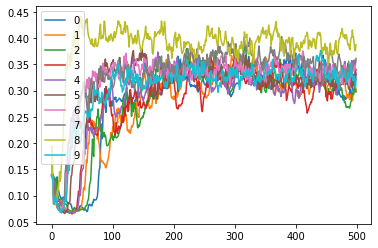

In [ ]:
RMSE = []
relErr = []
frameRe = []
print('RMSE \t Rel Err')
for idx in range(len(testSimFiles)):
    # testDataset = CCSI_2D([testSimFiles[idx]],doPreprocess=preprocess,channel=channel,AE=False)
    # simDataLoader = DataLoader(dataset=testDataset, batch_size=1)
    # for X,Y in simDataLoader:
    #     p = X[1]
    #     t = X[2]
    #     print(X[0].shape, p, t)

    testDataset = CCSI_2D([testSimFiles[idx]],doPreprocess=preprocess,channel=channel,AE=AE,w=0)
    simDataLoader = DataLoader(dataset=testDataset, batch_size=1)
    XX = []
    Real_X = []
    model.eval()
    for i, sampleBatch in enumerate(simDataLoader,start=1):
        with torch.no_grad():
            X, Y, p_x, p_y = sampleBatch
            X, Y, p_x, p_y = X.to(device), Y.to(device), p_x.to(device), p_y.to(device)
            Real_X.append(X)

            X_hat,_ = model(X, p_x)

            if createStreamFcn:
                X_hat = stream2uv(X_hat,device)

            XX.append(X_hat)

            #X = X.detach().cpu().squeeze()
            #X_hat = X_hat.detach().cpu().squeeze()
            #plotSampleWprediction(X, X_hat)

    Real_X = torch.cat(Real_X,axis=0).to('cpu')
    Real_X_img = torch.rot90(convertSimToImage(Real_X),1,dims=[2,3])

    Surr_X = torch.cat(XX,axis=0).to('cpu')
    Surr_X_img = torch.rot90(convertSimToImage(Surr_X),1,dims=[2,3])
    Real_X_img.shape, Surr_X_img.shape
    
    r = rmse(Real_X,Surr_X)
    RMSE.append(r)
    
    rel_error = torch.norm(Real_X - Surr_X)/torch.norm(Real_X)
    print('{}\t{}'.format(r, rel_error))
    relErr.append(rel_error)
    
    re = []
    for x,y in zip(Real_X, Surr_X):
        x = x.squeeze()
        y = y.squeeze()
        e = torch.norm(x - y)/torch.norm(x)
        re.append(e)
    frameRe.append(re)
    #plt.plot(re)
    
print(np.mean(relErr))
frameRe = np.vstack(frameRe)
plt.plot(frameRe.T)
plt.legend([i for i in range(len(testSimFiles))])
plt.show()

### Make Movie

In [ ]:
import matplotlib.animation as animation
import matplotlib.gridspec as gridspec
import matplotlib.animation as manimati
from matplotlib import animation, rc
def create_1_channel_movie(im,outfile='sim.mp4',title='surrogate            simulation'):
    ti = 0
    u_mx = 255 #np.max(np.abs(Xrgb))
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.title(title)
    cmap = plt.cm.ocean
    img = ax.imshow(im[0].squeeze(), cmap=cmap, vmin=0, vmax=u_mx)
    #plt.show()
    
    # initialization function: plot the background of each frame
    def init():
        img = ax.imshow(im[0].squeeze(), cmap=cmap, vmin=0, vmax=u_mx)
        return (fig,)

    # animation function. This is called sequentially
    def animate(i):
        img = ax.imshow(im[i].squeeze(), cmap=cmap, vmin=0, vmax=u_mx)
        return (fig,)


    # call the animator. blit=True means only re-draw the parts that have changed.
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=len(im), interval=20, blit=True)
    anim.save(outfile, fps=30, extra_args=['-vcodec', 'libx264'])

In [ ]:
Xrgb = torch.cat([Surr_X_img, Real_X_img], dim=3)
Xrgb.shape

torch.Size([500, 1, 128, 256])

In [ ]:
try:
    gif = True
    outGif = '{}.gif'.format(versionName)
    create_1_channel_movie(Xrgb.detach().numpy(),outfile=outGif)
except:
    gif = False
    outGif = '{}.mp4'.format(versionName)
    create_1_channel_movie(Xrgb.detach().numpy(),outfile=outGif)

MovieWriter stderr:
ffmpeg: /home/widemann1/anaconda3/lib/./libuuid.so.1: no version information available (required by /lib64/libSM.so.6)
[gif @ 0x2154700] GIF muxer supports only a single video GIF stream.
Could not write header for output file #0 (incorrect codec parameters ?): Invalid argument



In [ ]:
from IPython.display import Image, Video
if gif:
    Image(filename=outGif)
else:
    Video(outGif)

In [ ]:
Video(outGif)

In [ ]:
%matplotlib notebook
plt.hist(Surr_X.flatten(),bins=100)
plt.hist(Real_X.flatten(),bins=100)
plt.show()